In [143]:
from scipy.stats import boxcox
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.datasets import load_diabetes
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import ARDRegression
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import statsmodels.api as sm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import os
plt.style.use('ggplot')
pd.options.display.float_format = '{:.4f}'.format

## Сырые данные по РФ


In [144]:
# Пример данных
df = pd.read_csv('regional_data/raw_Российская_Федерация.csv')
df.drop(['paid_services', 'unemp'], axis=1, inplace=True)
y = df["inflation"] / 100
df.drop(['inflation', 'Date'], axis=1, inplace=True)
df.head()

trade_turnover    debt_firms  money_income  fm_changes_volume  \
0 1840650960.8000 18171671.0000    29535.0000           -33.6366   
1 1853102881.7600 18184819.0000    29233.0000             0.2397   
2 2032552773.8200 18458002.0000    31403.0000            10.3180   
3 2023565042.7000 18790056.0000    32949.0000             3.7917   
4 2075030365.1200 19052987.0000    32270.0000            -0.0284   

   fm_changes_costs  fm_changes_demand  fm_volume_exp  fm_demand_exp  \
0           16.5488           -18.9968        19.5241        17.8629   
1           19.8500            -5.4247        22.3260        20.6132   
2           21.9860             0.5802        21.6463        20.2543   
3           19.2108             0.6118        21.7094        19.7543   
4           17.3341            -1.8377        20.1813        17.8731   

   fm_price_exp  fm_credit_cond  ...  fm_consumer_risk  fm_price_final_prod  \
0       13.9747         -4.0841  ...          -26.8843               8.8840   
1       16.5072         -4.6556  ...          -12.1922               9.0326   
2       14.3095         -5.2060  ...           -6.8871               9.2950   
3       12.3721         -5.2451  ...           -7.2642               8.4533   
4       11.1985         -5.3272  ...           -9.3358               6.1958   

   fm_ibk  fm_econom_position  fm_econom_cond    Brent  MIACR  Infl_exp  \
0 -5.1940             -3.6629        -13.8711 108.1200 6.0565   13.0377   
1  9.0811             -3.0289         -7.6790 108.9000 5.9935   11.7952   
2 13.0283             -2.5626         -4.1967 107.4800 7.8450   11.5221   
3 11.2594             -1.8274         -3.6375 107.7600 7.8745   12.6727   
4  8.8062             -0.9382         -3.2577 109.5400 8.2147   11.7210   

          M2  obligates  
0 31155.6000     6.2005  
1 29861.2000     6.3855  
2 30169.0000     7.4024  
3 29519.3000     7.4977  
4 29879.0000     7.9550  

[5 rows x 21 columns]

## Как выглядит распределение рядов без обработки


In [145]:
df.plot(kind='line', figsize=(20, 20), subplots=True)

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >], dtype=object)

## У денежных переменных вычищаем инфляцию


In [146]:
df_infl = df[['M2', 'debt_firms', 'trade_turnover', 'money_income']].copy()
df.drop(['M2', 'debt_firms', 'trade_turnover', 'money_income'], axis=1, inplace=True)
df_infl = df_infl.dropna()
y = y.dropna()
for col in df_infl:
    for i in range(len(df_infl[col])):
        for j in range(i):
            df_infl.loc[i, col] = df_infl.loc[i, col] / y[j]
df = df.join(df_infl)
df_infl.plot(kind='line', figsize=(15, 12), subplots=True);

## Находим ряды с большой размерностью / экспоненциальным ростом и применяем логарифмирование


array([<Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object)

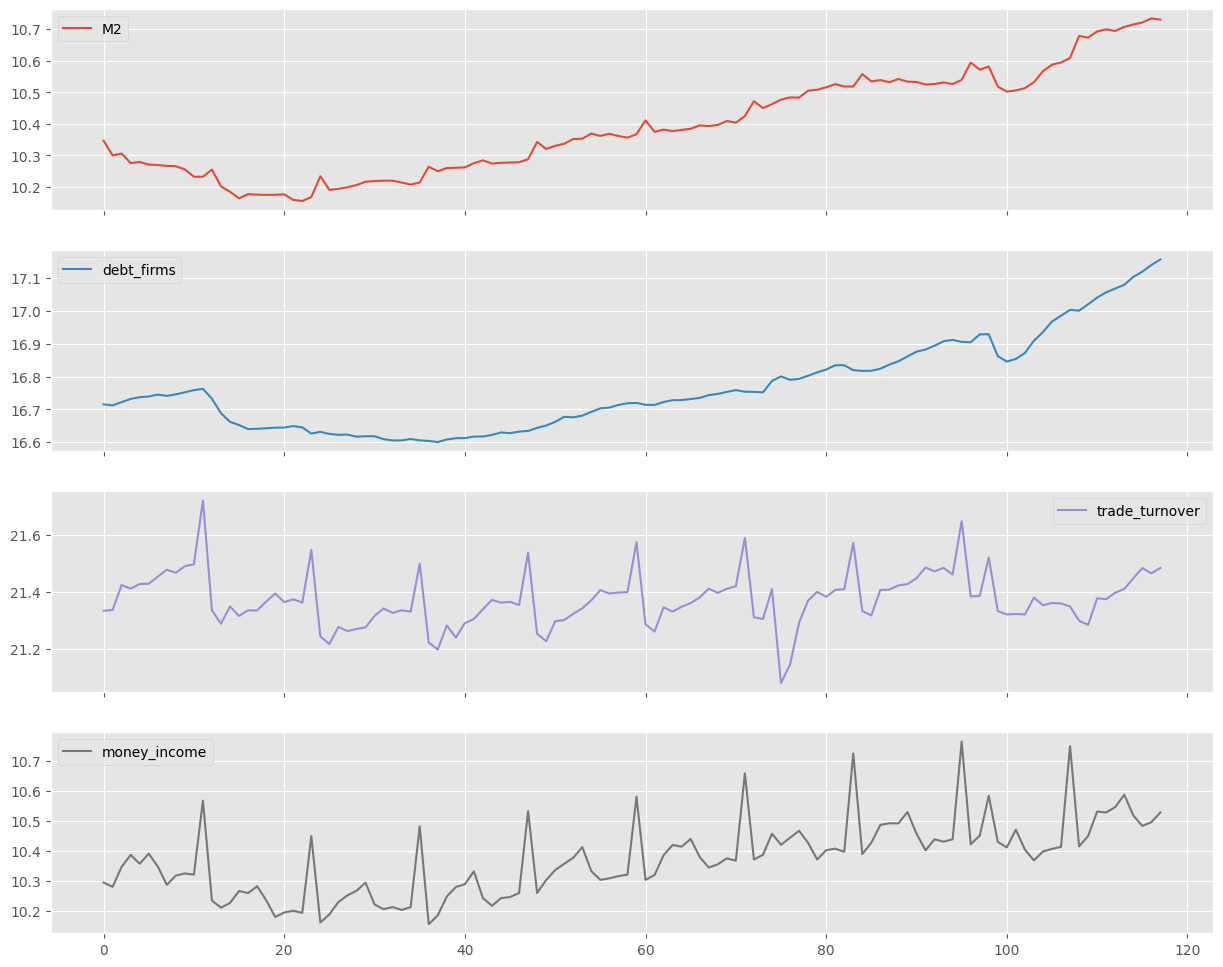

In [147]:
df_log = df[['M2', 'debt_firms','trade_turnover', 'money_income']].copy()
df.drop(['M2', 'debt_firms', 'trade_turnover','money_income'], axis=1, inplace=True)
df_log = df_log.apply(lambda x: np.log(x))
df = df.join(df_log)
df_log.plot(kind='line', figsize=(15, 12), subplots=True)

## Ищем ряды с ярко выраженной годовой сезонностью и применяем сезонную корректировку


In [148]:
from statsmodels.tsa.seasonal import STL

df = df.dropna()

df_seasonal = df[['fm_changes_volume', 'fm_changes_demand', 'fm_volume_exp', 'fm_demand_exp',
                  'fm_currency_index', 'fm_consumer_risk', 'fm_price_final_prod', 'fm_ibk',
                  'fm_econom_position', 'fm_econom_cond', 'M2', 'money_income', 'trade_turnover', 'debt_firms']].copy()

df.drop(['fm_changes_volume', 'fm_changes_demand', 'fm_volume_exp', 'fm_demand_exp',
         'fm_currency_index', 'fm_consumer_risk', 'fm_price_final_prod', 'fm_ibk',
         'fm_econom_position', 'fm_econom_cond', 'M2', 'money_income', 'trade_turnover', 'debt_firms'], axis=1, inplace=True)
df_seasonal = df_seasonal.apply(lambda x: x - STL(x, period=12).fit().seasonal)
df = df.join(df_seasonal)

Отдельно вычищаем безработицу, так как у неё сезонность по 11 месяцев


## Берем первые разности и приводим ряды к 1 размерности

### Проверяем ряды на стационарность


In [149]:
a_list = df.columns[df.apply(lambda x: adfuller(x)[1] > 0.05)].to_list()
df.loc[:, a_list] = df.loc[:, a_list].diff(1)
df = df.diff(1)
df = df.dropna()
df.apply(lambda x: adfuller(x)[1] < 0.05)

fm_changes_costs       True
fm_price_exp           True
fm_credit_cond         True
Brent                  True
MIACR                  True
Infl_exp               True
obligates              True
fm_changes_volume      True
fm_changes_demand      True
fm_volume_exp          True
fm_demand_exp          True
fm_currency_index      True
fm_consumer_risk       True
fm_price_final_prod    True
fm_ibk                 True
fm_econom_position     True
fm_econom_cond         True
M2                     True
money_income           True
trade_turnover         True
debt_firms             True
dtype: bool

## Итоговое распределение рядов


## Применяем Метод главных компонент для переменных - опроссов коньюктуры рынка

### Формируем компоненты, объясняющие 90% дисперсии Х


In [150]:
df = df.dropna()
X_fm = df[['fm_econom_cond', 'fm_econom_position', 'fm_price_final_prod', 'fm_consumer_risk', 'fm_currency_index',
           'fm_credit_cond', 'fm_price_exp', 'fm_demand_exp', 'fm_volume_exp', 'fm_changes_demand',
           'fm_changes_costs', 'fm_changes_volume']].copy()

X_fm.columns = ['Изм. эконом. конъюнктуры', 'Изм. эконом. полож', 'Изм. цен на готовую продукцию', 'Изм. рисков хозяйственной деят.',
                'Влияние изм. валютного курса', 'Изм. условий кредитования', 'Ожидания изм. цен на готовую продукцию', 'Ожидания изм. спроса на продукцию',
                'Ожидания изменение объемов произв.', 'Изм. спроса на продукцию', 'Изм. издержек производства', 'Изм. объемов производства']

X = df.drop(columns=['fm_econom_cond', 'fm_econom_position', 'fm_price_final_prod', 'fm_consumer_risk', 'fm_currency_index',
                     'fm_credit_cond', 'fm_price_exp', 'fm_demand_exp', 'fm_volume_exp', 'fm_changes_demand',
                     'fm_changes_costs', 'fm_changes_volume'])

# Стандартизация данных
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_fm)

pca = PCA(n_components=6)
X_pca = pca.fit_transform(X_scaled)

explained_variance = pca.explained_variance_ratio_
loadings = pca.components_

# Визуализация объясненной дисперсии компонентами  PCA
plt.figure(figsize=(8, 5), dpi=100)
bars = plt.bar(range(1, len(explained_variance) + 1),
               explained_variance, alpha=0.8, align='center')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height*100:.1f}%',
             ha='center', va='bottom', fontsize=9)
    
print(f"Общая объясненная дисперсия 6 компонентами: {sum(explained_variance)*100:.2f}%")
plt.xlabel('Номер компоненты')
plt.ylabel('Доля объясненной дисперсии')
plt.xticks(np.arange(1, len(explained_variance)+1, 1))
plt.title(f'Объясненная дисперсия PCA:   {sum(explained_variance)*100:.2f}%')
plt.show()

Общая объясненная дисперсия 6 компонентами: 92.10%


In [151]:
plt.figure(figsize=(12, 10), dpi=200)
loadings_data = pd.DataFrame(
    loadings, columns=X_fm.columns, index=range(1, 1+len(loadings))).T
loadings_data.columns = [f'Компонента_{i}' for i in range(1, 1+len(loadings))]
ax = sb.heatmap(loadings_data, annot=True, cmap='coolwarm', linewidth=.5)
ax.set(xlabel="", ylabel="")
ax.xaxis.tick_top()

In [152]:
X_pca_df = pd.DataFrame(X_pca)
X_pca_df.columns = [f'PCA_{j+1}' for j in range(len(X_pca[0]))]
X = X.join(X_pca_df).dropna()
X

Brent   MIACR  Infl_exp  obligates  fm_ibk      M2  money_income  \
2    -2.2000  1.8515   -0.2730     0.8319 -0.2427  0.0038        0.0149   
3     1.7000  0.0295    1.1506    -0.9215 -0.7958 -0.0126       -0.0202   
4     1.5000  0.3402   -0.9518     0.3619 -0.7848  0.0001       -0.0085   
5     0.4800  0.0184   -0.3722    -0.5299 -1.1025  0.0005        0.0143   
6    -7.2900 -0.0610    0.4816     0.7176  0.7237  0.0056       -0.0053   
..       ...     ...       ...        ...     ...     ...           ...   
111  10.3700 -0.1946    0.4511     0.9454 -1.2834  0.0252        0.0825   
112 -15.3800  0.0915   -0.6146    -0.5172  0.0437 -0.0245       -0.0462   
113   8.5400  0.0809    0.8679    -1.4646 -0.9839  0.0016       -0.0238   
114   5.9000  0.4952    0.4608    -0.3420  0.3129 -0.0021        0.0101   
115   0.7700  2.5042    0.2014     1.0788 -0.6908 -0.0064        0.0026   

     trade_turnover  debt_firms   PCA_1   PCA_2   PCA_3   PCA_4   PCA_5  \
2           -0.0064     -0.0016 -0.0268  0.1297 -0.3622 -0.0180 -0.5414   
3           -0.0042     -0.0073  0.4848 -0.0888 -0.0722 -0.6582 -0.5657   
4           -0.0071     -0.0016 -0.6948 -0.5255 -0.5830  0.9381  0.0552   
5            0.0009     -0.0065  0.4920  0.5230  0.5349 -0.7213  0.2653   
6           -0.0069      0.0018  0.5108 -0.8959 -0.2975  0.5004 -0.8679   
..              ...         ...     ...     ...     ...     ...     ...   
111          0.0764      0.0233  0.7619 -0.1404 -0.6084 -0.8809 -1.3484   
112         -0.0435     -0.0226 -0.1342 -0.9564 -0.4241  0.3276 -0.3677   
113         -0.0046     -0.0090  0.9463 -0.1383  0.6191 -0.1109 -0.0327   
114          0.0068      0.0018 -3.1271  0.4289  0.0386  0.1114 -0.4393   
115         -0.0270     -0.0083  0.2034  1.3464 -1.0332  0.2707  1.5850   

      PCA_6  
2    0.3020  
3   -0.0126  
4   -0.5857  
5    0.6676  
6   -0.5586  
..      ...  
111 -0.0087  
112 -0.1894  
113 -0.4033  
114  0.6838  
115 -0.2033  

[114 rows x 15 columns]

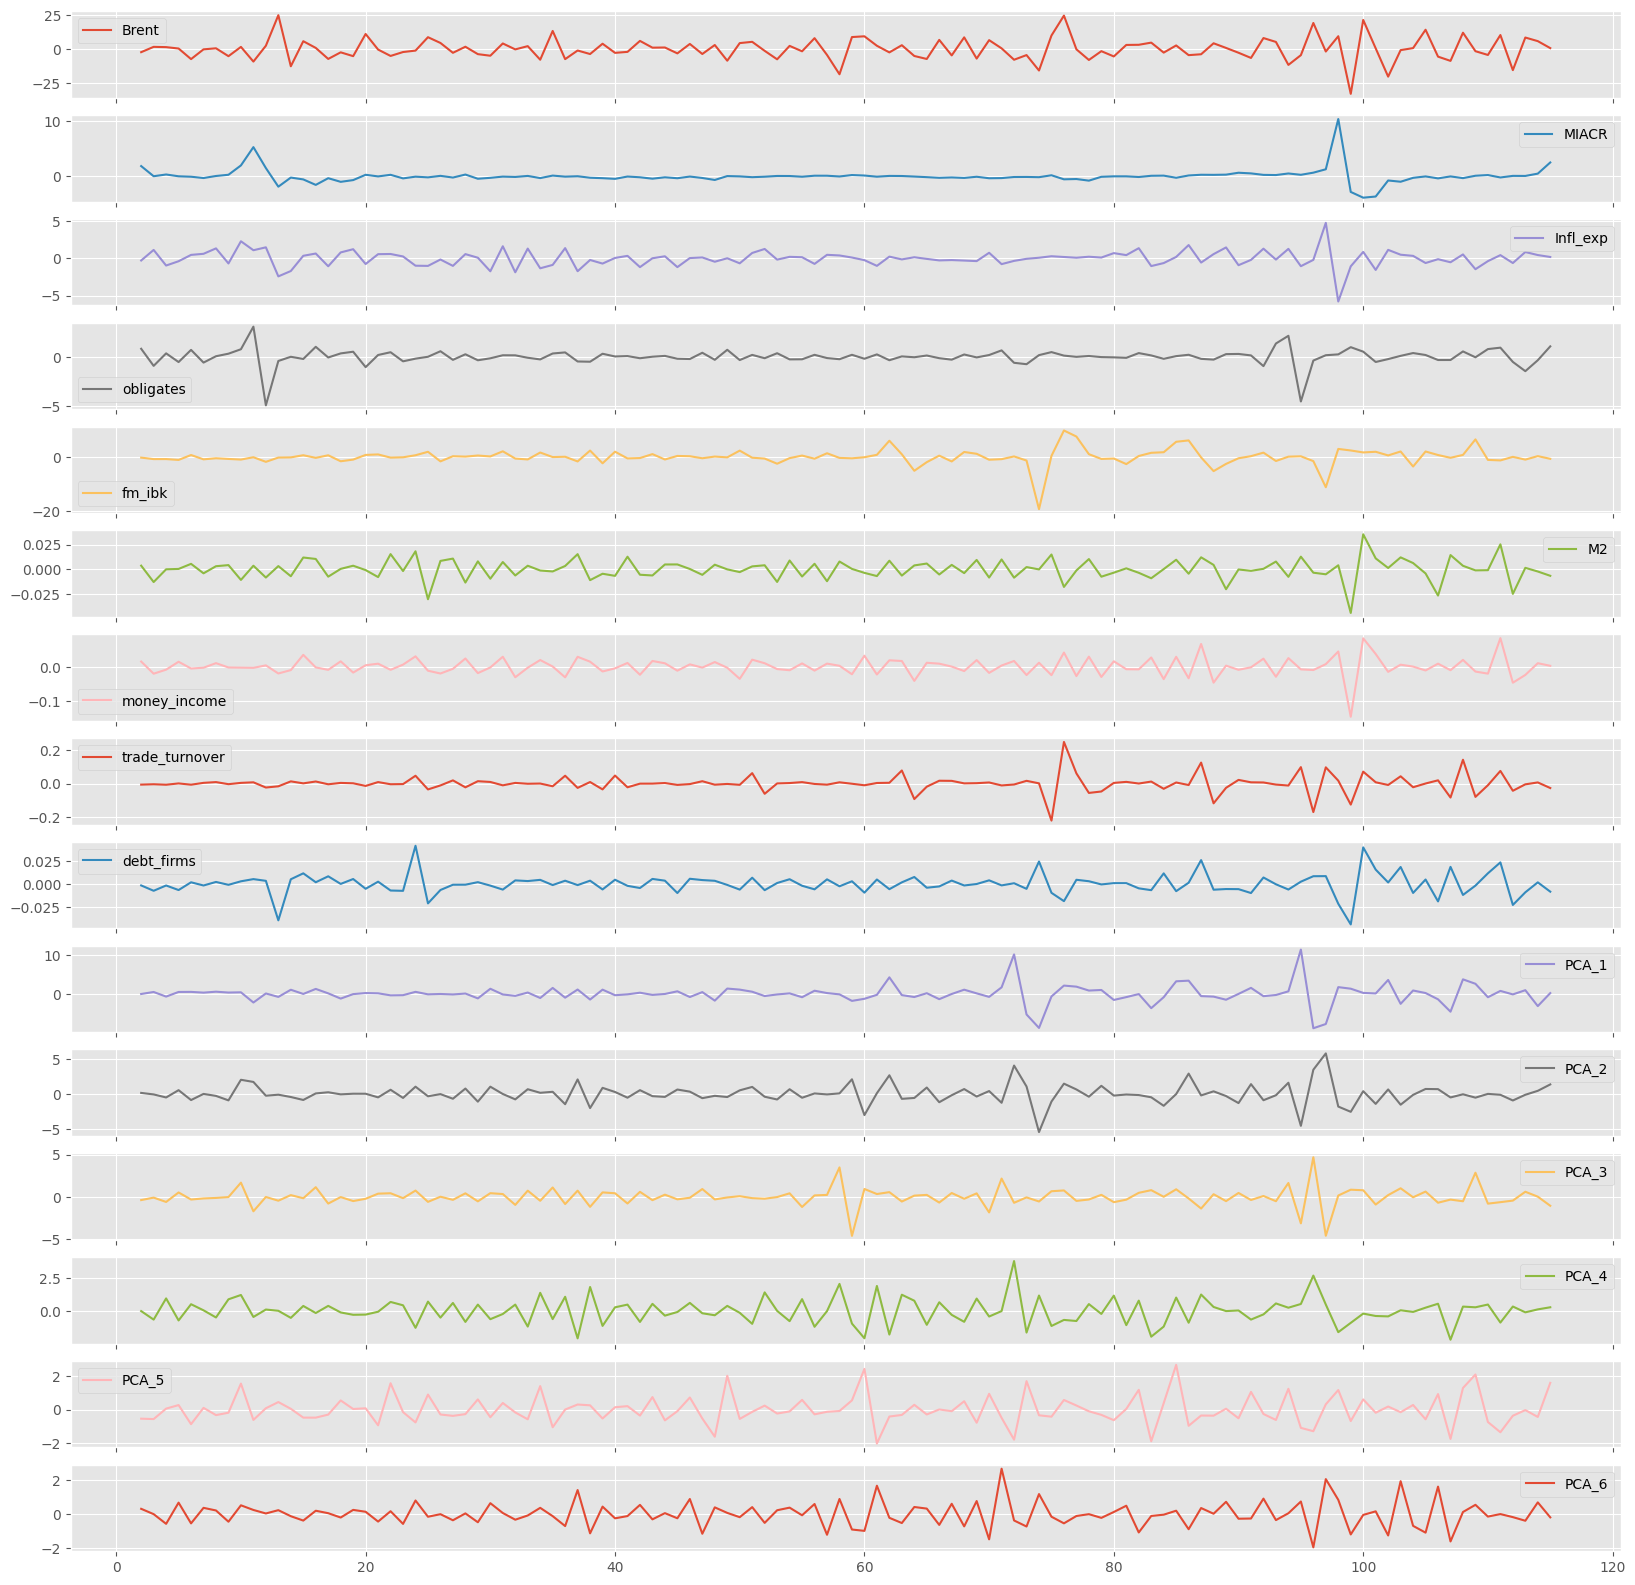

In [153]:
X.plot(subplots=True, figsize=(20, 20));

In [134]:
import os
os.makedirs('final_regional_df', exist_ok=True)
os.path.join(os.getcwd(), 'processed_regional_data')

'/Users/askar/Desktop/ВКР/Diploma.-Inflation-model-using-PCA/processed_regional_data'

In [135]:
df = X.join(y)
df.to_csv('final_regional_df/infl_Российская_Федерация.csv', index=False)

In [136]:
plt.figure(figsize=(20, 20))
sb.heatmap(df.corr(numeric_only=True), cmap="YlGnBu", annot=True)

<Axes: >

## Создание региональных таблиц по общему алгоритму

In [156]:
# Собираем списком названия файлов в папке
file_names = os.listdir('/Users/askar/Desktop/ВКР/Diploma.-Inflation-model-using-PCA/regional_data')
# Создаем папку, куда будем сохранять наши файлы
os.makedirs('final_regional_df', exist_ok=True)
# Создаем переменной название пути до папки с файлами (понадобится при импорте)
source_path = os.path.join(os.getcwd(), 'regional_data')

component_categories = {
    'Компонента спроса': ['Ожидания изм. спроса на продукцию', 'Изм. цен на готовую продукцию', 'Изм. спроса на продукцию'],
    'Компонента предложения': ['Изм. издержек производства'],
    'Компонента валютного канала': ['Влияние изм. валютного курса'],
    'Компонента ожидания': ['Ожидания изм. цен на готовую продукцию'],
    'Компонента рыночной конъюнктуры': ['Изм. эконом. конъюнктуры', 'Изм. эконом. полож', 'Ожидания изменение объемов произв.', 'Изм. объемов производства'],
    'Компонента денежного рынка': ['Изм. условий кредитования', 'Изм. рисков хозяйственной деят.']
}

# Функция для назначения имен компонентам
def name_components(loadings, feature_names):
    # Создаем словарь для хранения суммарных нагрузок по категориям для каждой компоненты
    component_scores = []
    
    for component in loadings:
        scores = {}
        for category, features in component_categories.items():
            # Находим индексы переменных этой категории
            indices = [i for i, name in enumerate(feature_names) if name in features]
            # Суммируем абсолютные значения нагрузок для этих переменных
            scores[category] = np.sum(np.abs([component[i] for i in indices]))
        component_scores.append(scores)
    
    # Назначаем каждой категории компоненту с максимальной суммарной нагрузкой
    category_to_component = {}
    used_components = set()
    
    for category in component_categories.keys():
        max_score = -1
        best_component = None
        
        for i, scores in enumerate(component_scores):
            if i not in used_components and scores[category] > max_score:
                max_score = scores[category]
                best_component = i
        
        if best_component is not None:
            category_to_component[category] = best_component
            used_components.add(best_component)
    
    # Создаем список имен компонент
    component_names = [""] * len(loadings)
    for category, component_idx in category_to_component.items():
        component_names[component_idx] = category
    
    # Оставшиеся компоненты называем "Дополнительная компонента X"
    for i in range(len(component_names)):
        if not component_names[i]:
            component_names[i] = f"Дополнительная компонента {i+1}"
    
    return component_names

for k in range(len(file_names)):
    # Используем путь до папки и название региона из списка
    df = pd.read_csv(f'{os.path.join(source_path, file_names[k])}').dropna()
    # Отделяем инфляцию и переводим ее в доли
    y = df["inflation"] / 100
    df.drop(['inflation', 'Date', 'paid_services', 'unemp'], axis=1, inplace=True)
    # У денежных рядов делаем корректировку на инфляцию (чтобы инфляция не объясняла сама себя)
    df_infl = df[['M2', 'debt_firms', 'trade_turnover', 'money_income']].copy()
    df.drop(['M2', 'debt_firms', 'trade_turnover', 'money_income'], axis=1, inplace=True)
    df_infl = df_infl.astype(float).dropna()
    df_infl.reset_index(drop=True, inplace=True)
    y.reset_index(drop=True, inplace=True)
    for col in df_infl:
        for i in range(len(df_infl[col])):
            for j in range(i):
                df_infl.loc[i, col] = df_infl.loc[i, col] / y[j]
    df = df.join(df_infl)
    # Логарифмируем ряды с большой размерностью
    df_log = df[['M2', 'debt_firms','trade_turnover', 'money_income']].copy()
    df.drop(['M2', 'debt_firms', 'trade_turnover','money_income'], axis=1, inplace=True)
    df_log = df_log.apply(lambda x: np.log(x))
    df = df.join(df_log)
    # Делаем сезонную корректировку рядов
    df = df.dropna()
    df_seasonal = df[['fm_changes_volume', 'fm_changes_demand', 'fm_volume_exp', 'fm_demand_exp',
                      'fm_currency_index', 'fm_consumer_risk', 'fm_price_final_prod',
                      'fm_econom_position', 'fm_econom_cond', 'M2', 'money_income', 'trade_turnover', 'debt_firms']].copy()
    df.drop(['fm_changes_volume', 'fm_changes_demand', 'fm_volume_exp', 'fm_demand_exp',
             'fm_currency_index', 'fm_consumer_risk', 'fm_price_final_prod',
             'fm_econom_position', 'fm_econom_cond', 'M2', 'money_income', 'trade_turnover', 'debt_firms'], axis=1, inplace=True)
    df_seasonal = df_seasonal.apply(
        lambda x: x - STL(x, period=12).fit().seasonal)
    df = df.join(df_seasonal)
    # Приводим к стационарности с помощью 1 разностей
    a_list = df.columns[df.apply(lambda x: adfuller(x)[1] > 0.05)].to_list()
    df.loc[:, a_list] = df.loc[:, a_list].diff(1)
    df = df.dropna()
    # Собираем главные компоненты
    X_fm = df[['fm_econom_cond', 'fm_econom_position', 'fm_price_final_prod', 'fm_consumer_risk', 'fm_currency_index',
               'fm_credit_cond', 'fm_price_exp', 'fm_demand_exp', 'fm_volume_exp', 'fm_changes_demand',
               'fm_changes_costs', 'fm_changes_volume']].copy()
    X_fm.columns = ['Изм. эконом. конъюнктуры', 'Изм. эконом. полож', 'Изм. цен на готовую продукцию', 'Изм. рисков хозяйственной деят.',
                    'Влияние изм. валютного курса', 'Изм. условий кредитования', 'Ожидания изм. цен на готовую продукцию', 'Ожидания изм. спроса на продукцию',
                    'Ожидания изменение объемов произв.', 'Изм. спроса на продукцию', 'Изм. издержек производства', 'Изм. объемов производства']
    X = df.drop(columns=['fm_econom_cond', 'fm_econom_position', 'fm_price_final_prod', 'fm_consumer_risk', 'fm_currency_index',
                         'fm_credit_cond', 'fm_price_exp', 'fm_demand_exp', 'fm_volume_exp', 'fm_changes_demand',
                         'fm_changes_costs', 'fm_changes_volume'])
    # Стандартизация данных, так как это чувствительная вещь
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_fm)
    pca = PCA(n_components=6)
    X_pca = pca.fit_transform(X_scaled)
    explained_variance = pca.explained_variance_ratio_
    loadings = pca.components_
    # Циклом проходимся по кол-ву главных компонент
    X_pca_df = pd.DataFrame(X_pca)
    component_names = name_components(loadings, X_fm.columns)
    X_pca_df.columns = component_names    
    X = X.join(X_pca_df).dropna()
    df = X.join(y)
    df.to_csv(f'final_regional_df/infl_{file_names[k][4:-4]}.csv', index=False)

## Распределение объясненной дисперсии по компонентам


In [157]:
with pd.ExcelWriter("Результаты регрессий и МГК/PCA_components.xlsx") as writer:
    for i in range(len(file_names)):
        df = pd.read_csv(f'{os.path.join(source_path, file_names[i])}')
        # Отделяем инфляцию и переводим ее в доли
        y = df["inflation"] / 100
        df.drop(['inflation', 'Date'], axis=1, inplace=True)
        df = df.dropna()
        # Собираем главные компоненты
        X_fm = df[['fm_econom_cond', 'fm_econom_position', 'fm_price_final_prod', 'fm_consumer_risk', 'fm_currency_index',
                'fm_credit_cond', 'fm_price_exp', 'fm_demand_exp', 'fm_volume_exp', 'fm_changes_demand',
                'fm_changes_costs', 'fm_changes_volume']].copy()
        X_fm.columns = ['Изм. эконом. конъюнктуры', 'Изм. эконом. полож', 'Изм. цен на готовую продукцию', 'Изм. рисков хозяйственной деят.',
                        'Влияние изм. валютного курса', 'Изм. условий кредитования', 'Ожидания изм. цен на готовую продукцию', 'Ожидания изм. спроса на продукцию',
                        'Ожидания изменение объемов произв.', 'Изм. спроса на продукцию', 'Изм. издержек производства', 'Изм. объемов производства']
        X = df.drop(columns=['fm_econom_cond', 'fm_econom_position', 'fm_price_final_prod', 'fm_consumer_risk', 'fm_currency_index',
                            'fm_credit_cond', 'fm_price_exp', 'fm_demand_exp', 'fm_volume_exp', 'fm_changes_demand',
                            'fm_changes_costs', 'fm_changes_volume'])
        # Стандартизация данных, так как это чувствительная вещь
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X_fm)
        pca = PCA(n_components=6)
        X_pca = pca.fit_transform(X_scaled)
        loadings = pd.DataFrame(pca.components_).T
        loadings.index = X_fm.columns
        loadings.to_excel(writer, sheet_name=f"{file_names[i][4:-4]}", index=True)

In [159]:
file_names = os.listdir('/Users/askar/Desktop/ВКР/Diploma.-Inflation-model-using-PCA/regional_data')
rows = 10
cols = 8
fig, axes = plt.subplots(rows, cols, figsize=(160, 160), dpi=100)


# Определяем категории переменных
component_categories = {
    'Компонента спроса': ['Ожидания изм. спроса на продукцию', 'Изм. цен на готовую продукцию', 'Изм. спроса на продукцию'],
    'Компонента предложения': ['Изм. издержек производства'],
    'Компонента валютного канала': ['Влияние изм. валютного курса'],
    'Компонента ожидания': ['Ожидания изм. цен на готовую продукцию'],
    'Компонента рыночной конъюнктуры': ['Изм. эконом. конъюнктуры', 'Изм. эконом. полож', 'Ожидания изменение объемов произв.', 'Изм. объемов производства'],
    'Компонента денежного рынка': ['Изм. условий кредитования', 'Изм. рисков хозяйственной деят.']
}

# Функция для назначения имен компонентам
def name_components(loadings, feature_names):
    # Создаем словарь для хранения суммарных нагрузок по категориям для каждой компоненты
    component_scores = []
    
    for component in loadings:
        scores = {}
        for category, features in component_categories.items():
            # Находим индексы переменных этой категории
            indices = [i for i, name in enumerate(feature_names) if name in features]
            # Суммируем абсолютные значения нагрузок для этих переменных
            scores[category] = np.sum(np.abs([component[i] for i in indices]))
        component_scores.append(scores)
    
    # Назначаем каждой категории компоненту с максимальной суммарной нагрузкой
    category_to_component = {}
    used_components = set()
    
    for category in component_categories.keys():
        max_score = -1
        best_component = None
        
        for i, scores in enumerate(component_scores):
            if i not in used_components and scores[category] > max_score:
                max_score = scores[category]
                best_component = i
        
        if best_component is not None:
            category_to_component[category] = best_component
            used_components.add(best_component)
    
    # Создаем список имен компонент
    component_names = [""] * len(loadings)
    for category, component_idx in category_to_component.items():
        component_names[component_idx] = category
    
    # Оставшиеся компоненты называем "Дополнительная компонента X"
    for i in range(len(component_names)):
        if not component_names[i]:
            component_names[i] = f"Дополнительная компонента {i+1}"
    
    return component_names

for i in range(len(file_names)):
    row = i // cols
    col = i % cols
    # Используем путь до папки и название региона из списка
    df = pd.read_csv(f'{os.path.join(source_path, file_names[i])}')
    # Отделяем инфляцию и переводим ее в доли
    y = df["inflation"] / 100
    df.drop(['inflation', 'Date'], axis=1, inplace=True)
    df = df.dropna()
    # Собираем главные компоненты
    X_fm = df[['fm_econom_cond', 'fm_econom_position', 'fm_price_final_prod', 'fm_consumer_risk', 'fm_currency_index',
               'fm_credit_cond', 'fm_price_exp', 'fm_demand_exp', 'fm_volume_exp', 'fm_changes_demand',
               'fm_changes_costs', 'fm_changes_volume']].copy()
    X_fm.columns = ['Изм. эконом. конъюнктуры', 'Изм. эконом. полож', 'Изм. цен на готовую продукцию', 'Изм. рисков хозяйственной деят.',
                    'Влияние изм. валютного курса', 'Изм. условий кредитования', 'Ожидания изм. цен на готовую продукцию', 'Ожидания изм. спроса на продукцию',
                    'Ожидания изменение объемов произв.', 'Изм. спроса на продукцию', 'Изм. издержек производства', 'Изм. объемов производства']
    X = df.drop(columns=['fm_econom_cond', 'fm_econom_position', 'fm_price_final_prod', 'fm_consumer_risk', 'fm_currency_index',
                         'fm_credit_cond', 'fm_price_exp', 'fm_demand_exp', 'fm_volume_exp', 'fm_changes_demand',
                         'fm_changes_costs', 'fm_changes_volume'])
    # Стандартизация данных, так как это чувствительная вещь
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_fm)
    pca = PCA(n_components=6)
    X_pca = pca.fit_transform(X_scaled)
    
    explained_variance = pca.explained_variance_ratio_
    loadings = pca.components_
    
    component_names = name_components(loadings, X_fm.columns)
    
    bars = axes[row, col].bar(component_names, explained_variance, alpha=0.8, align='center')
    for bar in bars:
        height = bar.get_height()
        axes[row, col].text(bar.get_x() + bar.get_width()/2., height, f'{height*100:.1f}%', ha='center', va='bottom', fontsize=9)
    axes[row, col].set_xticks(np.arange(len(component_names)))
    axes[row, col].set_xticklabels(component_names, rotation=45, ha='right', fontsize=12)
    axes[row, col].tick_params(axis='y', labelsize=14)
    axes[row, col].set_title(f'{file_names[i][4:-4]}:  {sum(explained_variance)*100:.2f}%', fontsize=24)
plt.savefig('result/pca_region.pdf')

## Распределение переменных по компонентам


In [160]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np

# Определяем категории переменных
component_categories = {
    'Компонента спроса': ['Ожидания изм. спроса на продукцию', 'Изм. цен на готовую продукцию', 'Изм. спроса на продукцию'],
    'Компонента предложения': ['Изм. издержек производства'],
    'Компонента валютного канала': ['Влияние изм. валютного курса'],
    'Компонента ожидания': ['Ожидания изм. цен на готовую продукцию'],
    'Компонента рыночной конъюнктуры': ['Изм. эконом. конъюнктуры', 'Изм. эконом. полож', 'Ожидания изменение объемов произв.', 'Изм. объемов производства'],
    'Компонента денежного рынка': ['Изм. условий кредитования', 'Изм. рисков хозяйственной деят.']
}

# Функция для назначения имен компонентам
def name_components(loadings, feature_names):
    # Создаем словарь для хранения суммарных нагрузок по категориям для каждой компоненты
    component_scores = []
    
    for component in loadings:
        scores = {}
        for category, features in component_categories.items():
            # Находим индексы переменных этой категории
            indices = [i for i, name in enumerate(feature_names) if name in features]
            # Суммируем абсолютные значения нагрузок для этих переменных
            scores[category] = np.sum(np.abs([component[i] for i in indices]))
        component_scores.append(scores)
    
    # Назначаем каждой категории компоненту с максимальной суммарной нагрузкой
    category_to_component = {}
    used_components = set()
    
    for category in component_categories.keys():
        max_score = -1
        best_component = None
        
        for i, scores in enumerate(component_scores):
            if i not in used_components and scores[category] > max_score:
                max_score = scores[category]
                best_component = i
        
        if best_component is not None:
            category_to_component[category] = best_component
            used_components.add(best_component)
    
    # Создаем список имен компонент
    component_names = [""] * len(loadings)
    for category, component_idx in category_to_component.items():
        component_names[component_idx] = category
    
    # Оставшиеся компоненты называем "Дополнительная компонента X"
    for i in range(len(component_names)):
        if not component_names[i]:
            component_names[i] = f"Дополнительная компонента {i+1}"
    
    return component_names

file_names = os.listdir('/Users/askar/Desktop/ВКР/Diploma.-Inflation-model-using-PCA/regional_data')
rows = 10
cols = 8
fig, axes = plt.subplots(rows, cols, figsize=(140, 140), dpi=150)

for i in range(len(file_names)):
    row = i // cols
    col = i % cols
    # Используем путь до папки и название региона из списка
    df = pd.read_csv(f'{os.path.join(source_path, file_names[i])}')
    # Отделяем инфляцию и переводим ее в доли
    y = df["inflation"] / 100
    df.drop(['inflation', 'Date'], axis=1, inplace=True)
    df = df.dropna()
    # Собираем главные компоненты
    X_fm = df.loc[:, ['fm_econom_cond', 'fm_econom_position', 'fm_price_final_prod', 'fm_consumer_risk', 'fm_currency_index',
                      'fm_credit_cond', 'fm_price_exp', 'fm_demand_exp', 'fm_volume_exp', 'fm_changes_demand',
                      'fm_changes_costs', 'fm_changes_volume']].copy()
    X_fm.columns = ['Изм. эконом. конъюнктуры', 'Изм. эконом. полож', 'Изм. цен на готовую продукцию', 'Изм. рисков хозяйственной деят.',
                    'Влияние изм. валютного курса', 'Изм. условий кредитования', 'Ожидания изм. цен на готовую продукцию', 'Ожидания изм. спроса на продукцию',
                    'Ожидания изменение объемов произв.', 'Изм. спроса на продукцию', 'Изм. издержек производства', 'Изм. объемов производства']
    X = df.drop(columns=['fm_econom_cond', 'fm_econom_position', 'fm_price_final_prod', 'fm_consumer_risk', 'fm_currency_index',
                         'fm_credit_cond', 'fm_price_exp', 'fm_demand_exp', 'fm_volume_exp', 'fm_changes_demand',
                         'fm_changes_costs', 'fm_changes_volume'])
    # Стандартизация данных
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_fm)
    pca = PCA(n_components=6)
    X_pca = pca.fit_transform(X_scaled)
    explained_variance = pca.explained_variance_ratio_
    loadings = pca.components_
    
    # Получаем имена для компонент
    component_names = name_components(loadings, X_fm.columns)
    
    # Создаем DataFrame с нагрузками
    loadings_data = pd.DataFrame(loadings, columns=X_fm.columns).T
    loadings_data.columns = component_names
    
    # Строим тепловую карту
    sb.heatmap(loadings_data, annot=True, cmap='coolwarm', linewidth=.5, ax=axes[row, col], 
               annot_kws={"size": 14}, cbar_kws={"shrink": 0.6})
    axes[row, col].set_title(f'{file_names[i][4:-4]}', fontsize=24)
    axes[row, col].tick_params(axis='both', which='major', labelsize=14)

plt.tight_layout() 
plt.savefig('result/fm_in_pca.png', bbox_inches='tight')
plt.show()